In [92]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import itertools

from sklearn import tree, metrics

import umap
import lightgbm as lgb

import optuna
import optuna.integration.lightgbm as lgb_opt

# Load Features

In [82]:
hazard = 1e-2
changepoint = pd.read_pickle(f'bayes changepoint/feature {hazard:.0e}.pickle')
changepoint.shape

(5193671, 12)

In [83]:
slope_i,slope_j = 3,5
std_i,std_j = 3,2
l1_nn = pd.read_pickle(f'dense_nn_trend_std/feature {slope_i}-{slope_j} {std_i}-{std_j}.pickle')
l1_nn.shape

(5262401, 2)

In [84]:
# Join features
feature = pd.concat((changepoint,l1_nn),axis=1).dropna()
feature

,,best_slope,best_idx,best_t,best_mean,close_minus_best_intercept,best_se,sec_best_slope,sec_best_idx,sec_best_t,sec_best_mean,close_minus_sec_best_intercept,sec_best_se,slope,std
datetime,ticker,,,,,,,,,,,,,,
2018-12-06,AAAU,0.000818,15.0,2.675504,-8.5,0.007697,0.000725,0.003342,2.0,3.223280,-2.0,0.001925,0.000032,0.007984,0.018814
2018-12-07,AAAU,0.003139,3.0,4.558485,-2.5,0.009772,0.000033,0.003204,4.0,6.560595,-3.0,0.009664,0.000033,0.005233,0.012483
2018-12-10,AAAU,0.003850,4.0,6.046192,-3.0,-0.001291,0.000057,0.003743,5.0,7.819045,-3.5,-0.001076,0.000058,0.000966,0.015387
2018-12-11,AAAU,0.003422,5.0,6.393244,-3.5,-0.004286,0.000072,0.002306,8.0,4.636215,-5.0,-0.001121,0.000245,0.000879,0.011897
2018-12-12,AAAU,0.002908,6.0,5.704163,-4.0,-0.002264,0.000109,0.002244,3.0,2.144267,-2.5,-0.001220,0.000077,0.002160,0.009889
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-30,ZSL,-0.016791,12.0,-10.248092,-7.0,-0.024527,0.009771,-0.015692,13.0,-10.014113,-7.5,-0.029655,0.011687,-0.008428,0.031025
2023-12-01,ZSL,-0.016961,13.0,-11.810355,-7.5,-0.021768,0.009817,-0.015965,14.0,-11.478212,-8.0,-0.026747,0.011840,-0.006173,0.030516
2023-12-04,ZSL,-0.014612,2.0,-5.934493,-2.0,0.070398,0.000182,-0.017055,14.0,-13.453685,-8.0,0.067625,0.009835,-0.000732,0.031168


# Load Target

In [15]:
predict_days = 10
bound_percent = 1.0

target = pd.read_pickle(f'target/barrier/barrier {bound_percent:.1f}, {predict_days} days.pickle')

# Segment Data

In [16]:
# Share index
index = feature.index.intersection(target.index)
feature = feature.loc[index]
target = target.loc[index]

In [17]:
all_datetime = feature.index.get_level_values(0).unique().sort_values()

train_end_idx = int(0.7*all_datetime.shape[0])
train_end = all_datetime[train_end_idx]
test_end_idx = int((0.7+0.15)*all_datetime.shape[0])
test_end  = all_datetime[test_end_idx]
train_end_idx, test_end_idx, train_end, test_end

(3280,
 3983,
 Timestamp('2018-05-04 00:00:00'),
 Timestamp('2021-02-19 00:00:00'))

In [20]:
X_train = feature[feature.index.get_level_values(0) < train_end].drop(columns=['best_mean', 'sec_best_mean'])
Y_train = target[target.index.get_level_values(0) < train_end]

X_test = feature[(train_end <= feature.index.get_level_values(0))
                 & (feature.index.get_level_values(0) < test_end)].drop(columns=['best_mean', 'sec_best_mean'])
Y_test = target[(train_end <= feature.index.get_level_values(0))
                 & (feature.index.get_level_values(0) < test_end)]

X_valid = feature[test_end <= feature.index.get_level_values(0)].drop(columns=['best_mean', 'sec_best_mean'])
Y_valid = target[test_end <= target.index.get_level_values(0)]

# Parameter Search

In [38]:
params = {'objective': 'multiclass','metric':'multi_logloss','num_classes':3,'verbosity':-1}
dtrain = lgb.Dataset(X_train.values, label=(Y_train.values+1 != 0))
dtest = lgb.Dataset(X_test.values, label=(Y_test.values+1 != 0))

In [39]:
study = optuna.create_study()
booster = lgb_opt.train(params, dtrain, valid_sets=[dtrain, dtest],valid_names=['train','test'],
                    study = study,
                    show_progress_bar=False,
                    callbacks=[lgb.early_stopping(100,verbose=False), lgb.log_evaluation(100)])

[I 2024-08-19 09:57:30,267] A new study created in memory with name: no-name-935010e3-7d52-496f-810c-d38949b1fdb9


[100]	train's multi_logloss: 0.611416	test's multi_logloss: 0.587976


[I 2024-08-19 09:58:03,653] Trial 0 finished with value: 0.587172272124231 and parameters: {'feature_fraction': 0.8999999999999999}. Best is trial 0 with value: 0.587172272124231.


[100]	train's multi_logloss: 0.611804	test's multi_logloss: 0.587747


[I 2024-08-19 09:58:37,123] Trial 1 finished with value: 0.5868001992647472 and parameters: {'feature_fraction': 0.6}. Best is trial 1 with value: 0.5868001992647472.


[100]	train's multi_logloss: 0.611406	test's multi_logloss: 0.588048


[I 2024-08-19 09:59:09,489] Trial 2 finished with value: 0.5871192718789007 and parameters: {'feature_fraction': 0.8}. Best is trial 1 with value: 0.5868001992647472.


[100]	train's multi_logloss: 0.612099	test's multi_logloss: 0.587617


[I 2024-08-19 09:59:42,590] Trial 3 finished with value: 0.5866237146305991 and parameters: {'feature_fraction': 0.4}. Best is trial 3 with value: 0.5866237146305991.


[100]	train's multi_logloss: 0.611657	test's multi_logloss: 0.587784


[I 2024-08-19 10:00:15,085] Trial 4 finished with value: 0.5868632913610479 and parameters: {'feature_fraction': 0.7}. Best is trial 3 with value: 0.5866237146305991.


[100]	train's multi_logloss: 0.612194	test's multi_logloss: 0.587714


[I 2024-08-19 10:00:51,260] Trial 5 finished with value: 0.5868504858749835 and parameters: {'feature_fraction': 0.5}. Best is trial 3 with value: 0.5866237146305991.


[100]	train's multi_logloss: 0.611246	test's multi_logloss: 0.588229


[I 2024-08-19 10:01:23,156] Trial 6 finished with value: 0.5871800772117757 and parameters: {'feature_fraction': 1.0}. Best is trial 3 with value: 0.5866237146305991.


[100]	train's multi_logloss: 0.617416	test's multi_logloss: 0.586772


[I 2024-08-19 10:01:50,997] Trial 7 finished with value: 0.58634156711552 and parameters: {'num_leaves': 3}. Best is trial 7 with value: 0.58634156711552.


[100]	train's multi_logloss: 0.602573	test's multi_logloss: 0.589155


[I 2024-08-19 10:02:31,405] Trial 8 finished with value: 0.5873305840460793 and parameters: {'num_leaves': 167}. Best is trial 7 with value: 0.58634156711552.


[100]	train's multi_logloss: 0.60203	test's multi_logloss: 0.589379


[I 2024-08-19 10:03:12,619] Trial 9 finished with value: 0.5873990680138406 and parameters: {'num_leaves': 176}. Best is trial 7 with value: 0.58634156711552.


[100]	train's multi_logloss: 0.61503	test's multi_logloss: 0.587153


[I 2024-08-19 10:03:41,330] Trial 10 finished with value: 0.5864782738930523 and parameters: {'num_leaves': 11}. Best is trial 7 with value: 0.58634156711552.


[100]	train's multi_logloss: 0.617416	test's multi_logloss: 0.586772


[I 2024-08-19 10:04:09,008] Trial 11 finished with value: 0.58634156711552 and parameters: {'num_leaves': 3}. Best is trial 7 with value: 0.58634156711552.


[100]	train's multi_logloss: 0.618353	test's multi_logloss: 0.586729


[I 2024-08-19 10:04:43,705] Trial 12 finished with value: 0.5866360364838811 and parameters: {'num_leaves': 2}. Best is trial 7 with value: 0.58634156711552.


[100]	train's multi_logloss: 0.608551	test's multi_logloss: 0.588249


[I 2024-08-19 10:05:20,445] Trial 13 finished with value: 0.5869366322942541 and parameters: {'num_leaves': 71}. Best is trial 7 with value: 0.58634156711552.


[100]	train's multi_logloss: 0.607873	test's multi_logloss: 0.588383


[I 2024-08-19 10:05:57,592] Trial 14 finished with value: 0.5869841403013328 and parameters: {'num_leaves': 80}. Best is trial 7 with value: 0.58634156711552.


[100]	train's multi_logloss: 0.609804	test's multi_logloss: 0.588035


[I 2024-08-19 10:06:32,372] Trial 15 finished with value: 0.5868377501973656 and parameters: {'num_leaves': 57}. Best is trial 7 with value: 0.58634156711552.


[100]	train's multi_logloss: 0.598364	test's multi_logloss: 0.589758


[I 2024-08-19 10:07:17,354] Trial 16 finished with value: 0.5874919610797397 and parameters: {'num_leaves': 251}. Best is trial 7 with value: 0.58634156711552.


[100]	train's multi_logloss: 0.61162	test's multi_logloss: 0.587759


[I 2024-08-19 10:07:49,844] Trial 17 finished with value: 0.5867137335566762 and parameters: {'num_leaves': 36}. Best is trial 7 with value: 0.58634156711552.


[100]	train's multi_logloss: 0.606188	test's multi_logloss: 0.588704


[I 2024-08-19 10:08:28,213] Trial 18 finished with value: 0.5871491026053337 and parameters: {'num_leaves': 108}. Best is trial 7 with value: 0.58634156711552.


[100]	train's multi_logloss: 0.612099	test's multi_logloss: 0.587617


[I 2024-08-19 10:09:00,965] Trial 19 finished with value: 0.5866237146305991 and parameters: {'num_leaves': 31}. Best is trial 7 with value: 0.58634156711552.


[100]	train's multi_logloss: 0.605295	test's multi_logloss: 0.588829


[I 2024-08-19 10:09:39,792] Trial 20 finished with value: 0.5871341464327857 and parameters: {'num_leaves': 120}. Best is trial 7 with value: 0.58634156711552.


[100]	train's multi_logloss: 0.616925	test's multi_logloss: 0.586893


[I 2024-08-19 10:10:06,191] Trial 21 finished with value: 0.5863173351617854 and parameters: {'num_leaves': 4}. Best is trial 21 with value: 0.5863173351617854.


[100]	train's multi_logloss: 0.617416	test's multi_logloss: 0.586772


[I 2024-08-19 10:10:33,947] Trial 22 finished with value: 0.58634156711552 and parameters: {'num_leaves': 3}. Best is trial 21 with value: 0.5863173351617854.


[100]	train's multi_logloss: 0.611057	test's multi_logloss: 0.587792


[I 2024-08-19 10:11:09,274] Trial 23 finished with value: 0.58679561673694 and parameters: {'num_leaves': 42}. Best is trial 21 with value: 0.5863173351617854.


[100]	train's multi_logloss: 0.613099	test's multi_logloss: 0.587335


[I 2024-08-19 10:11:41,937] Trial 24 finished with value: 0.5865814700526357 and parameters: {'num_leaves': 23}. Best is trial 21 with value: 0.5863173351617854.


[100]	train's multi_logloss: 0.608341	test's multi_logloss: 0.588273


[I 2024-08-19 10:12:23,838] Trial 25 finished with value: 0.5870182147483669 and parameters: {'num_leaves': 75}. Best is trial 21 with value: 0.5863173351617854.


[100]	train's multi_logloss: 0.610538	test's multi_logloss: 0.58776


[I 2024-08-19 10:12:59,455] Trial 26 finished with value: 0.5868116888835934 and parameters: {'num_leaves': 47}. Best is trial 21 with value: 0.5863173351617854.


[100]	train's multi_logloss: 0.616913	test's multi_logloss: 0.586836


[I 2024-08-19 10:13:27,710] Trial 27 finished with value: 0.5862411193535161 and parameters: {'bagging_fraction': 0.8870092642594228, 'bagging_freq': 6}. Best is trial 27 with value: 0.5862411193535161.


[100]	train's multi_logloss: 0.616912	test's multi_logloss: 0.586908


[I 2024-08-19 10:13:55,837] Trial 28 finished with value: 0.5862487900418035 and parameters: {'bagging_fraction': 0.9007906028687381, 'bagging_freq': 6}. Best is trial 27 with value: 0.5862411193535161.


[100]	train's multi_logloss: 0.616921	test's multi_logloss: 0.586779


[I 2024-08-19 10:14:24,154] Trial 29 finished with value: 0.5862333374077769 and parameters: {'bagging_fraction': 0.9195934193804269, 'bagging_freq': 6}. Best is trial 29 with value: 0.5862333374077769.


[100]	train's multi_logloss: 0.616942	test's multi_logloss: 0.586894


[I 2024-08-19 10:14:52,970] Trial 30 finished with value: 0.5862818294477908 and parameters: {'bagging_fraction': 0.9312729091365869, 'bagging_freq': 6}. Best is trial 29 with value: 0.5862333374077769.


[100]	train's multi_logloss: 0.616894	test's multi_logloss: 0.586908


[I 2024-08-19 10:15:21,143] Trial 31 finished with value: 0.5862677918144263 and parameters: {'bagging_fraction': 0.9212267903217375, 'bagging_freq': 6}. Best is trial 29 with value: 0.5862333374077769.


[100]	train's multi_logloss: 0.616894	test's multi_logloss: 0.586854


[I 2024-08-19 10:15:49,636] Trial 32 finished with value: 0.586260785580434 and parameters: {'bagging_fraction': 0.9099432667470542, 'bagging_freq': 6}. Best is trial 29 with value: 0.5862333374077769.


[100]	train's multi_logloss: 0.616892	test's multi_logloss: 0.586846


[I 2024-08-19 10:16:17,790] Trial 33 finished with value: 0.5862886743384091 and parameters: {'bagging_fraction': 0.8978804558321531, 'bagging_freq': 6}. Best is trial 29 with value: 0.5862333374077769.


[100]	train's multi_logloss: 0.616903	test's multi_logloss: 0.586861


[I 2024-08-19 10:16:46,119] Trial 34 finished with value: 0.5862262524373427 and parameters: {'bagging_fraction': 0.8742244365004499, 'bagging_freq': 6}. Best is trial 34 with value: 0.5862262524373427.


[100]	train's multi_logloss: 0.616904	test's multi_logloss: 0.586828


[I 2024-08-19 10:17:13,369] Trial 35 finished with value: 0.5862104028632947 and parameters: {'bagging_fraction': 0.756494069269185, 'bagging_freq': 5}. Best is trial 35 with value: 0.5862104028632947.


[100]	train's multi_logloss: 0.616886	test's multi_logloss: 0.58684


[I 2024-08-19 10:17:40,658] Trial 36 finished with value: 0.586225340169113 and parameters: {'bagging_fraction': 0.6852921668871467, 'bagging_freq': 4}. Best is trial 35 with value: 0.5862104028632947.


[100]	train's multi_logloss: 0.616904	test's multi_logloss: 0.586828


[I 2024-08-19 10:18:08,927] Trial 37 finished with value: 0.5862104028632947 and parameters: {'feature_fraction': 0.44800000000000006}. Best is trial 37 with value: 0.5862104028632947.


[100]	train's multi_logloss: 0.616971	test's multi_logloss: 0.586815


[I 2024-08-19 10:18:42,275] Trial 38 finished with value: 0.5865107112491129 and parameters: {'feature_fraction': 0.48000000000000004}. Best is trial 37 with value: 0.5862104028632947.


[100]	train's multi_logloss: 0.616904	test's multi_logloss: 0.586828


[I 2024-08-19 10:19:09,652] Trial 39 finished with value: 0.5862104028632947 and parameters: {'feature_fraction': 0.41600000000000004}. Best is trial 37 with value: 0.5862104028632947.


[100]	train's multi_logloss: 0.616904	test's multi_logloss: 0.586828


[I 2024-08-19 10:19:39,675] Trial 40 finished with value: 0.5862104028975731 and parameters: {'lambda_l1': 8.604733699969573e-05, 'lambda_l2': 2.502962705134278e-06}. Best is trial 40 with value: 0.5862104028975731.


[100]	train's multi_logloss: 0.616904	test's multi_logloss: 0.586828


[I 2024-08-19 10:20:08,959] Trial 41 finished with value: 0.5862104028944214 and parameters: {'lambda_l1': 7.786719595492483e-05, 'lambda_l2': 2.3798299616041024e-06}. Best is trial 41 with value: 0.5862104028944214.


[100]	train's multi_logloss: 0.616904	test's multi_logloss: 0.586828


[I 2024-08-19 10:20:40,180] Trial 42 finished with value: 0.5862104029184776 and parameters: {'lambda_l1': 0.00015604770322015076, 'lambda_l2': 1.2521126694526095e-06}. Best is trial 41 with value: 0.5862104028944214.


[100]	train's multi_logloss: 0.616904	test's multi_logloss: 0.586828


[I 2024-08-19 10:21:10,250] Trial 43 finished with value: 0.5862104028817641 and parameters: {'lambda_l1': 5.659364170025413e-05, 'lambda_l2': 3.0877870946249306e-06}. Best is trial 43 with value: 0.5862104028817641.


[100]	train's multi_logloss: 0.616904	test's multi_logloss: 0.586828


[I 2024-08-19 10:21:41,097] Trial 44 finished with value: 0.586210403853761 and parameters: {'lambda_l1': 5.2479801378472635e-08, 'lambda_l2': 0.005027959576036261}. Best is trial 43 with value: 0.5862104028817641.


[100]	train's multi_logloss: 0.616904	test's multi_logloss: 0.586828


[I 2024-08-19 10:22:09,813] Trial 45 finished with value: 0.5862104254544916 and parameters: {'lambda_l1': 0.060862581865799535, 'lambda_l2': 2.791028620624129e-08}. Best is trial 43 with value: 0.5862104028817641.


[100]	train's multi_logloss: 0.616904	test's multi_logloss: 0.586828


[I 2024-08-19 10:22:44,420] Trial 46 finished with value: 0.5862104028738645 and parameters: {'lambda_l1': 1.9003996655800073e-06, 'lambda_l2': 5.154108493053362e-05}. Best is trial 46 with value: 0.5862104028738645.


[100]	train's multi_logloss: 0.616935	test's multi_logloss: 0.586816


[I 2024-08-19 10:23:15,235] Trial 47 finished with value: 0.5862522489029031 and parameters: {'lambda_l1': 1.9140192560868328e-07, 'lambda_l2': 1.1751284323423994}. Best is trial 46 with value: 0.5862104028738645.


[100]	train's multi_logloss: 0.616904	test's multi_logloss: 0.586828


[I 2024-08-19 10:23:42,404] Trial 48 finished with value: 0.5862104029626096 and parameters: {'lambda_l1': 2.374538860593191e-06, 'lambda_l2': 0.000479029847768345}. Best is trial 46 with value: 0.5862104028738645.


[100]	train's multi_logloss: 0.616904	test's multi_logloss: 0.586828


[I 2024-08-19 10:24:10,003] Trial 49 finished with value: 0.5862104207406015 and parameters: {'lambda_l1': 0.048112602252216786, 'lambda_l2': 2.874088395698967e-05}. Best is trial 46 with value: 0.5862104028738645.


[100]	train's multi_logloss: 0.616904	test's multi_logloss: 0.586828


[I 2024-08-19 10:24:37,370] Trial 50 finished with value: 0.5862104049891876 and parameters: {'lambda_l1': 2.4417122700319307e-06, 'lambda_l2': 0.010771691187133326}. Best is trial 46 with value: 0.5862104028738645.


[100]	train's multi_logloss: 0.616904	test's multi_logloss: 0.586828


[I 2024-08-19 10:25:04,459] Trial 51 finished with value: 0.586210403137938 and parameters: {'lambda_l1': 0.0008014791886412747, 'lambda_l2': 5.028657875479871e-07}. Best is trial 46 with value: 0.5862104028738645.


[100]	train's multi_logloss: 0.616904	test's multi_logloss: 0.586828


[I 2024-08-19 10:25:31,681] Trial 52 finished with value: 0.586210402878376 and parameters: {'lambda_l1': 1.7007068562578376e-05, 'lambda_l2': 4.601658642251417e-05}. Best is trial 46 with value: 0.5862104028738645.


[100]	train's multi_logloss: 0.616904	test's multi_logloss: 0.586828


[I 2024-08-19 10:25:59,074] Trial 53 finished with value: 0.5862104028854178 and parameters: {'lambda_l1': 4.953878501023743e-06, 'lambda_l2': 0.0001121874262738545}. Best is trial 46 with value: 0.5862104028738645.


[100]	train's multi_logloss: 0.616904	test's multi_logloss: 0.586828


[I 2024-08-19 10:26:28,374] Trial 54 finished with value: 0.586210404161428 and parameters: {'lambda_l1': 0.0034162936374152013, 'lambda_l2': 5.3299451314215064e-05}. Best is trial 46 with value: 0.5862104028738645.


[100]	train's multi_logloss: 0.616904	test's multi_logloss: 0.586828


[I 2024-08-19 10:26:57,478] Trial 55 finished with value: 0.5862104033990855 and parameters: {'lambda_l1': 7.474617181445878e-06, 'lambda_l2': 0.0026648777546510196}. Best is trial 46 with value: 0.5862104028738645.


[100]	train's multi_logloss: 0.616904	test's multi_logloss: 0.586828


[I 2024-08-19 10:27:24,785] Trial 56 finished with value: 0.5862104028633215 and parameters: {'lambda_l1': 1.2511619212942744e-08, 'lambda_l2': 5.146808565516531e-08}. Best is trial 56 with value: 0.5862104028633215.


[100]	train's multi_logloss: 0.616939	test's multi_logloss: 0.586801


[I 2024-08-19 10:27:51,817] Trial 57 finished with value: 0.5862438365762002 and parameters: {'lambda_l1': 9.968175213512424, 'lambda_l2': 1.0157180641715902e-07}. Best is trial 56 with value: 0.5862104028633215.


[100]	train's multi_logloss: 0.616896	test's multi_logloss: 0.586845


[I 2024-08-19 10:28:19,028] Trial 58 finished with value: 0.5862129975322299 and parameters: {'lambda_l1': 1.097880445816661e-08, 'lambda_l2': 2.0227199439726955}. Best is trial 56 with value: 0.5862104028633215.


[100]	train's multi_logloss: 0.616904	test's multi_logloss: 0.58683


[I 2024-08-19 10:28:46,374] Trial 59 finished with value: 0.5862104272925702 and parameters: {'lambda_l1': 3.8651517387721555e-07, 'lambda_l2': 0.12317734291250801}. Best is trial 56 with value: 0.5862104028633215.


[100]	train's multi_logloss: 0.616904	test's multi_logloss: 0.586828


[I 2024-08-19 10:29:13,727] Trial 60 finished with value: 0.5862104028632947 and parameters: {'min_child_samples': 10}. Best is trial 60 with value: 0.5862104028632947.


[100]	train's multi_logloss: 0.6169	test's multi_logloss: 0.586828


[I 2024-08-19 10:29:40,707] Trial 61 finished with value: 0.5862104028632947 and parameters: {'min_child_samples': 25}. Best is trial 60 with value: 0.5862104028632947.


[100]	train's multi_logloss: 0.616905	test's multi_logloss: 0.586815


[I 2024-08-19 10:30:08,094] Trial 62 finished with value: 0.5862104028632947 and parameters: {'min_child_samples': 50}. Best is trial 60 with value: 0.5862104028632947.


[100]	train's multi_logloss: 0.616887	test's multi_logloss: 0.586826


[I 2024-08-19 10:30:35,475] Trial 63 finished with value: 0.5862104028632947 and parameters: {'min_child_samples': 100}. Best is trial 60 with value: 0.5862104028632947.


[100]	train's multi_logloss: 0.616904	test's multi_logloss: 0.586828


[I 2024-08-19 10:31:02,723] Trial 64 finished with value: 0.5862104028632947 and parameters: {'min_child_samples': 5}. Best is trial 60 with value: 0.5862104028632947.


In [40]:
booster.params

{'objective': 'multiclass',
 'metric': 'multi_logloss',
 'num_classes': 3,
 'verbosity': -1,
 'feature_pre_filter': False,
 'lambda_l1': 0.0,
 'lambda_l2': 0.0,
 'num_leaves': 4,
 'feature_fraction': 0.4,
 'bagging_fraction': 0.756494069269185,
 'bagging_freq': 5,
 'min_child_samples': 20,
 'num_iterations': 1000}

# Train

In [87]:
X_train

,,best_slope,best_idx,best_t,close_minus_best_intercept,best_se,sec_best_slope,sec_best_idx,sec_best_t,close_minus_sec_best_intercept,sec_best_se,slope,std
datetime,ticker,,,,,,,,,,,,
2005-04-25,AAA,-0.004135,5.0,-1.883538,-0.010657,0.001214,-0.002229,6.0,-1.100676,-0.015104,0.001723,-0.001199,0.014470
2005-04-26,AAA,-0.004570,6.0,-2.658531,-0.006351,0.001241,-0.002932,7.0,-1.759851,-0.010720,0.001831,-0.001982,0.012596
2005-04-27,AAA,-0.004667,7.0,-3.400658,0.003414,0.001243,-0.003286,8.0,-2.388827,-0.000730,0.001873,-0.000691,0.013099
2005-04-28,AAA,-0.004300,8.0,-3.770199,-0.048473,0.001288,-0.003187,9.0,-2.781708,-0.052181,0.001877,-0.005440,0.018352
2005-04-29,AAA,-0.005999,9.0,-4.395350,-0.023940,0.002663,-0.010933,2.0,-1.846615,-0.013103,0.001052,-0.005142,0.018218
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-04-27,ZSL,0.005149,6.0,1.238840,0.014383,0.007255,0.009459,5.0,2.201179,0.004325,0.004654,0.001741,0.019077
2018-04-30,ZSL,0.005652,7.0,1.698365,0.028029,0.007311,0.009117,6.0,2.734074,0.018791,0.004670,0.003740,0.021311
2018-05-01,ZSL,0.006670,8.0,2.398991,0.036187,0.007652,0.009645,7.0,3.602170,0.027262,0.004731,0.005967,0.019500


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Info] Number of positive: 1783930, number of negative: 606633
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008243 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2693
[LightGBM] [Info] Number of data points in the train set: 2390563, number of used features: 12
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

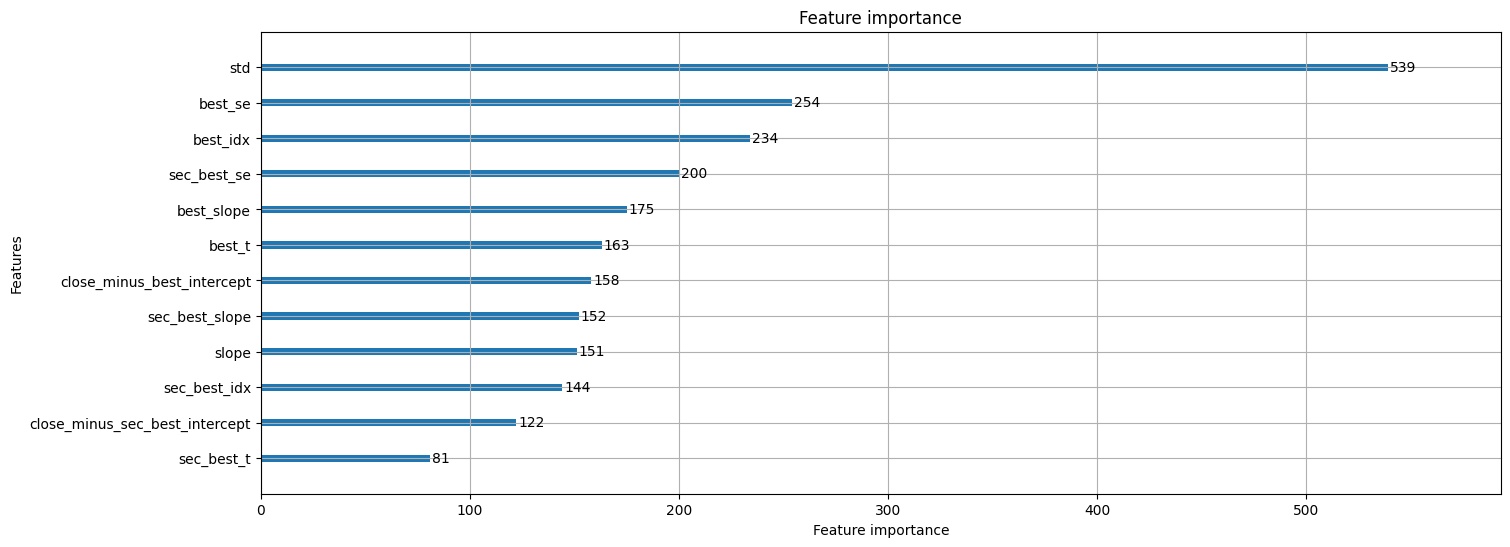

In [42]:
blf = lgb.LGBMClassifier(num_leaves = 4, n_estimators = 1000,
                        reg_alpha=0.0,reg_lambda=0.0,
                         feature_fraction=0.4,bagging_freq=5,min_child_samples=20)

# In: False, Out: True
blf.fit(X_train, Y_train != 0, eval_set=[(X_test.values, Y_test.values != 0)],
        callbacks=[lgb.early_stopping(100,verbose=False)])

fig, ax = plt.subplots(1,figsize=(16,6))
lgb.plot_importance(blf,ax=ax)

[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4


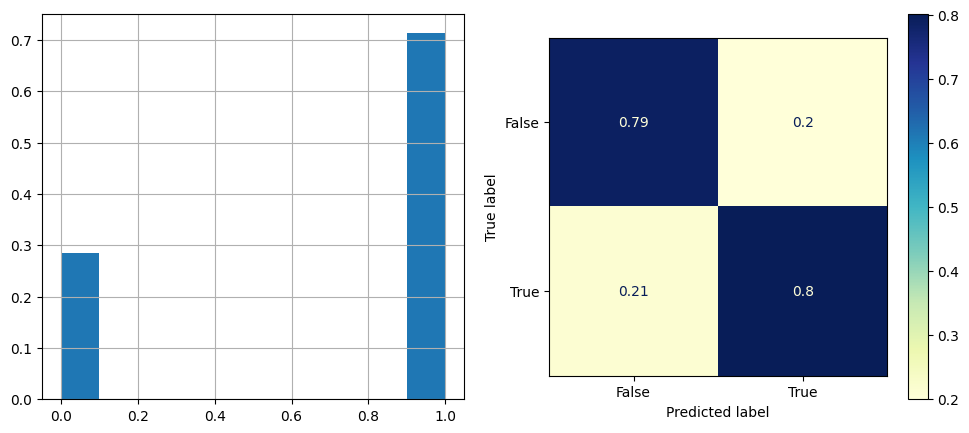

In [60]:
test_pred=blf.predict(X_test)

fig, ax = plt.subplots(1,2,figsize=(12,5))
(Y_test != 0).astype('i').hist(ax=ax[0],weights=np.ones_like(Y_test)/len(Y_test))

cm = metrics.confusion_matrix(Y_test != 0, test_pred,normalize='pred')
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=blf.classes_)

disp.plot(ax=ax[1],cmap='YlGnBu')

In [48]:
train_pred = blf.predict(X_train)

Y_train_proba = blf.predict_proba(X_train)
Y_test_proba = blf.predict_proba(X_test)

[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4


"\nfig, ax = plt.subplots(3,3,figsize=(12,6))\nfor i,j in itertools.product(range(3),range(3)):\n    train_proba = y_train_proba[(y_train == i-1) & (train_pred == j-1),j]\n    test_proba = y_test_proba[(y_test == i-1) & (test_pred == j-1),j]\n    ax[i,j].hist(train_proba,25,weights=np.ones_like(train_proba)/len(train_proba),\n                 alpha=0.5,label='train')\n    ax[i,j].hist(test_proba,25,weights=np.ones_like(test_proba)/len(test_proba),\n                 alpha=0.5,label='test')\n    ax[i,j].set_xlim(0,1)\n    ax[i,j].set_ylim(0,0.3)\n    ax[i,j].grid()\n    ax[i,j].legend()\n\nfig, ax = plt.subplots(2,3,figsize=(12,6))\nfor j in range(3):\n    for i in range(3):\n        train_proba = y_train_proba[(y_train == i-1) & (train_pred == j-1),j]\n        ax[0,j].hist(train_proba,25,weights=np.ones_like(train_proba)/len(train_proba),\n                   alpha=0.5,label=str(i-1))\n        test_proba = y_test_proba[(y_test == i-1) & (test_pred == j-1),j]\n        ax[1,j].hist(test_pr

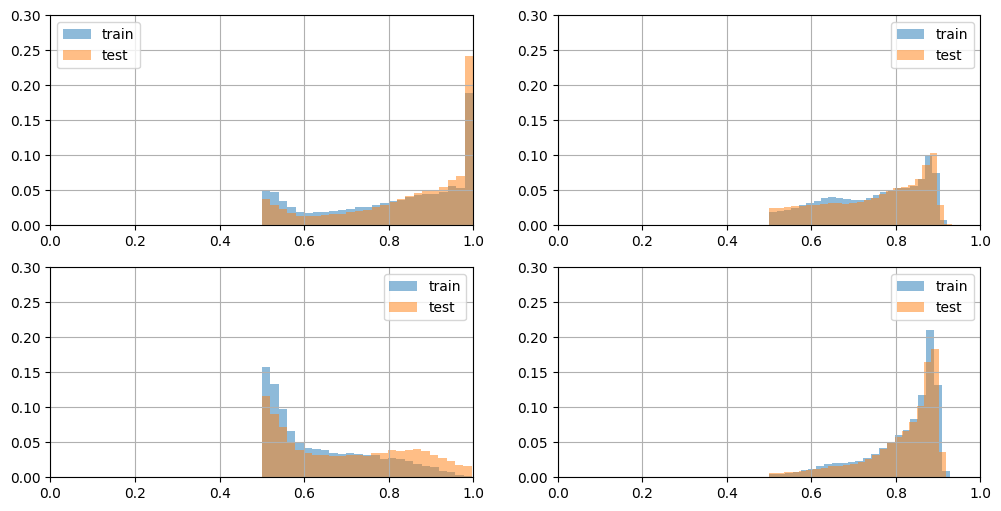

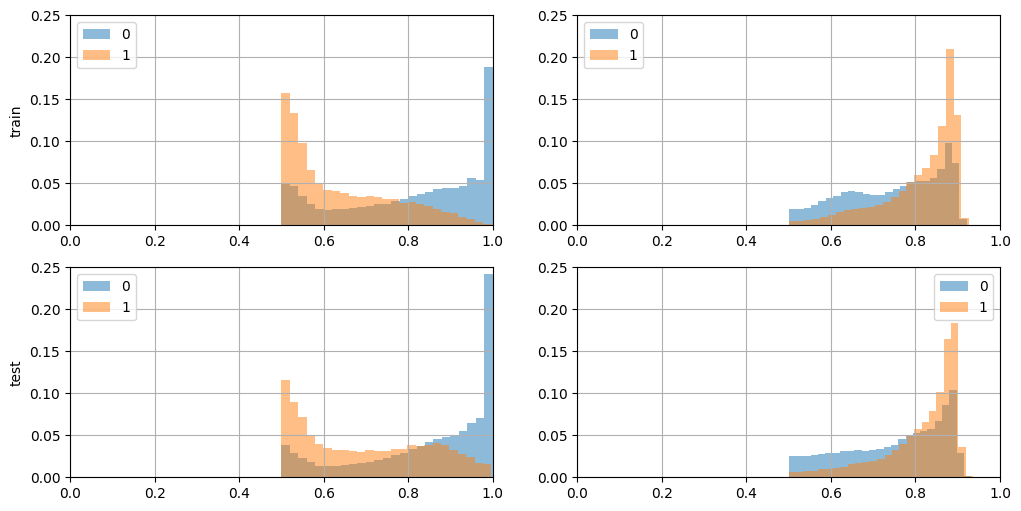

In [61]:
fig, ax = plt.subplots(2,2,figsize=(12,6))
for i,j in itertools.product(range(2),range(2)):
    train_proba = Y_train_proba[(Y_train == i) & (train_pred == j),j]
    test_proba = Y_test_proba[(Y_test == i) & (test_pred == j),j]
    ax[i,j].hist(train_proba,25,weights=np.ones_like(train_proba)/len(train_proba),
                 alpha=0.5,label='train')
    ax[i,j].hist(test_proba,25,weights=np.ones_like(test_proba)/len(test_proba),
                 alpha=0.5,label='test')
    ax[i,j].set_xlim(0,1)
    ax[i,j].set_ylim(0,0.3)
    ax[i,j].grid()
    ax[i,j].legend()

fig, ax = plt.subplots(2,2,figsize=(12,6))
for j in range(2):
    for i in range(2):
        train_proba = Y_train_proba[(y_train == i) & (train_pred == j),j]
        ax[0,j].hist(train_proba,25,weights=np.ones_like(train_proba)/len(train_proba),
                   alpha=0.5,label=str(i))
        test_proba = Y_test_proba[(y_test == i) & (test_pred == j),j]
        ax[1,j].hist(test_proba,25,weights=np.ones_like(test_proba)/len(test_proba),
                   alpha=0.5,label=str(i))
    ax[0,j].legend()
    ax[0,j].set_xlim(0,1)
    ax[0,j].set_ylim(0,0.25)
    ax[0,j].grid()
    ax[0,0].set_ylabel('train')

    ax[1,j].legend()
    ax[1,j].set_xlim(0,1)
    ax[1,j].set_ylim(0,0.25)
    ax[1,j].grid()
    ax[1,0].set_ylabel('test')

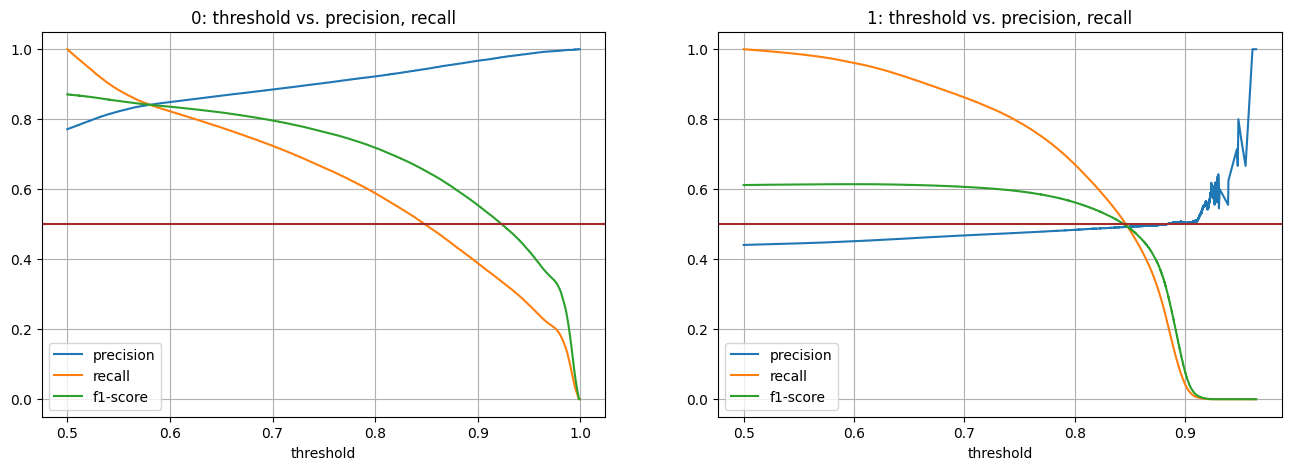

In [57]:
fig, ax = plt.subplots(1,2,figsize=(16,5))

for i in range(2):
    precision, recall, threshold \
        = metrics.precision_recall_curve(Y_train[train_pred == i] == i,
                                         Y_train_proba[train_pred == i,i])
    f1_score = 2*precision*recall/(precision + recall)
    
    ax[i].plot(threshold,precision[:-1],label='precision')
    ax[i].plot(threshold,recall[:-1],label='recall')
    ax[i].plot(threshold,f1_score[:-1],label='f1-score')
    ax[i].axhline(0.5,color='brown')
    ax[i].legend()
    ax[i].grid()
    ax[i].set_title(f'{i}: threshold vs. precision, recall')
    ax[i].set_xlabel('threshold')

# Per Day performance

But this still does not mean we can trade it. Consider hypothetically precision is 75% for three ETFs for two days. The first day has all ETF values greater than threshold and was successful. On the second day, two ETFs below threshold and one being failure. Then we overall have one success day and one fail day cancelling it out. Hence, we need to look at the per-day success, not per opportunity.

In [64]:
train_pred_df = pd.DataFrame(train_pred,index=X_train.index)
train_proba_df = pd.DataFrame(Y_train_proba,index=X_train.index,columns=(0,1))

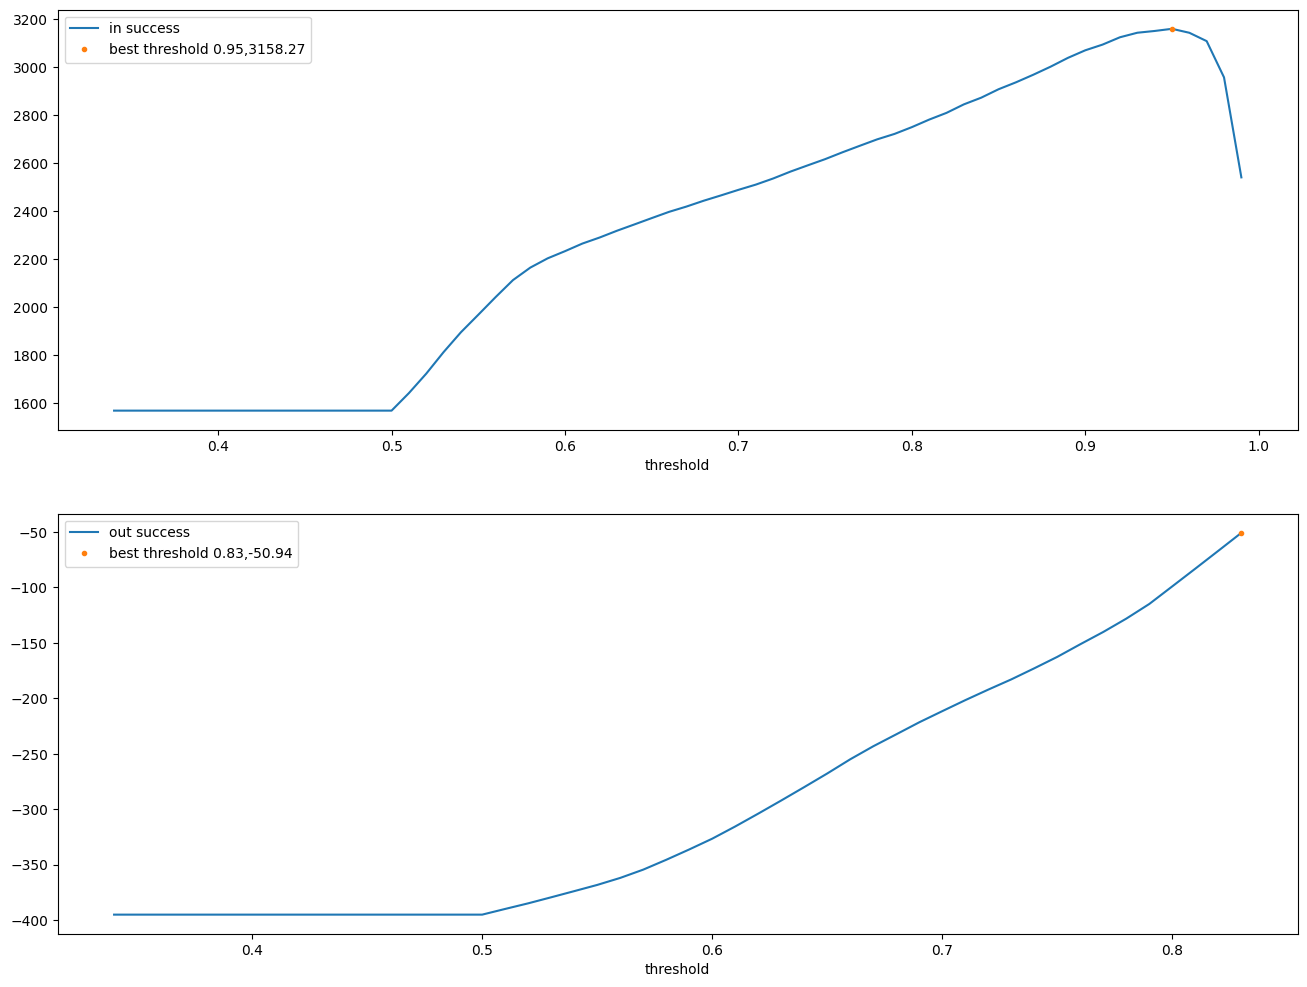

In [69]:
fig, ax = plt.subplots(2,figsize=(16,12))
in_success = [(2*(0 == y_train[train_pred == 0][train_proba_df[train_pred == 0].loc[:,0] > e])-1
                 ).groupby(level=[0]).mean().sum()
    for e in np.arange(0.34,1,0.01)]
ax[0].plot(np.arange(0.34,1,0.01),bound_success,label='in success')
ax[0].plot(np.arange(0.34,1,0.01)[np.argmax(bound_success)],np.max(bound_success),'.',
           label=f'best threshold {np.arange(0.34,1,0.01)[np.argmax(bound_success)]:.2f},{np.max(bound_success):.2f}')
ax[0].set_xlabel('threshold')
ax[0].legend()

out_success = [(2*(1 == y_train[train_pred == 1][train_proba_df[train_pred == 1].loc[:,1] > e])-1
              ).groupby(level=[0]).mean().sum()
    for e in np.arange(0.34,0.84,0.01)]
ax[1].plot(np.arange(0.34,0.84,0.01),up_success,label='out success')
ax[1].plot(np.arange(0.34,0.84,0.01)[np.argmax(up_success)],np.max(up_success),'.',
           label=f'best threshold {np.arange(0.34,0.84,0.01)[np.argmax(up_success)]:.2f},{np.max(up_success):.2f}')
ax[1].set_xlabel('threshold')
ax[1].legend()

In [95]:
import pickle
import base64

pickle_bytes = pickle.dumps(blf)
base64_str = base64.b64encode(pickle_bytes).decode('utf-8')

# Save the model string to a file on your local machine
with open('SK_10_1.0.txt', 'w') as file:
    file.write(base64_str)